In [1]:
# This notebook computes and plots the results for Figure 1 in the paper

import matplotlib.pyplot as plt
import numpy as np
from expected_cost import ec, utils
from expected_cost.data import get_llks_for_multi_classif_task
import os

In [2]:
dataset = 'gaussian_sim'

dataset_name = os.path.basename(dataset)

outdir = f'outputs/{dataset_name}'
utils.mkdir_p(outdir)

if dataset == 'gaussian_sim':
    # Simulation parameters
    N = 100000      # total number of samples
    var = 0.20      # within-class standard deviation of the features, determines the difficulty of the problem
    P0 = 0.8        # Prior for class 0, 0.8 or 0.5 for the results in the paper
    P1 = 1-P0
    N0 = int(N*P0)
    N1 = N - N0
    priors = [P0, P1]
else:
    priors, var, N = None, None, None

# Generate or read the log posteriors

targets, _, logpost = get_llks_for_multi_classif_task(dataset, priors=priors, sim_params={'feat_var': var}, N=N, logpost=True)

if dataset != 'gaussian_sim':
    N = len(targets)
    N0 = np.sum(targets==0)
    N1 = np.sum(targets==1)
    P0 = N0/N
    P1 = N1/N
    print(P0, P1)

cbal = P0/P1 # c21 corresponding to the balanced error rate

# We take the logits as scores, since they look prettier
# than log posteriors when plotted.

scores = logpost[:,1]-logpost[:,0]    

# Define various NEC with c12=1 and varying c21. 
cs = np.unique([1, cbal, 4, 16])
costs = dict([(c,[]) for c in cs])

# Define the range of thresholds to explore and determine the Bayes threshold for each cost function above.
xlim = [-7, 5]
delta = 0.1
thrs = np.arange(xlim[0], xlim[1]+delta, delta)      

selthris = [] # Indices of the Bayes threshold for each cost
for c in cs:
    costs[c] = ec.CostMatrix([[0, 1], [c, 0]])
    bayes_thr = np.log(1/c)
    selthris.append(np.argmin(np.abs(thrs-bayes_thr)))

out_name = "%s/results_for_prior1_%.2f"%(outdir,P0)
print("Dumping plots in %s*"%out_name)


Dumping plots in outputs/gaussian_sim/results_for_prior1_0.80*


c21 corresponding to the optimal threshold for F1 (-0.60): 1.82
c21 corresponding to the optimal threshold for MCC (-0.30): 1.35


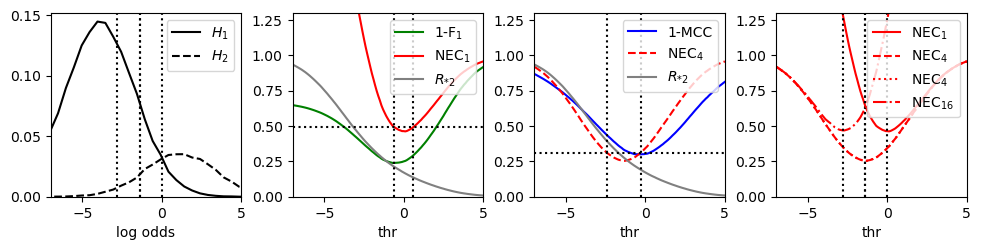

In [3]:
fig1, axs1 = plt.subplots(1, 4, figsize=(10,2.6))

# Compute and save all metrics across a range of thresholds
# Rij is the fraction of samples of class i that was labelled as j. When i=s (star) it means
# "both classes". So, Rs1 is the fraction of samples labelled as class 1 by the system.

F1Ss, MCCs, R10s, R01s, Rs1s = [], [], [], [], []
ECs = dict([(c,[]) for c in cs])

for thr in thrs:

    decisions = np.array(scores > thr, dtype=int) 

    conf = ec.generalized_confusion_matrix(targets, decisions, num_targets=2, num_decisions=2)

    # Save the error rates for plotting
    N10 = conf[1,0]
    N01 = conf[0,1]
    R10s.append(N10/N1)
    R01s.append(N01/N0)
    Rs1s.append(np.sum(decisions==1)/len(decisions))
    
    for c in cs:
        ECs[c].append(ec.average_cost(targets, decisions, costs[c], adjusted=True))
    F1Ss.append(utils.Fscore(N10, N01, N0, N1))
    MCCs.append(utils.MCCoeff(N10, N01, N0, N1))

    
# Plot distributions

ax = axs1[0]
c, h = utils.make_hist(targets, scores, nbins=50)
ax.plot(c,h[0]*P0,'k-', label='$H_1$')
ax.plot(c,h[1]*P1,'k--', label='$H_2$')

ax.set_xlabel('log odds')
ylim = list(ax.get_ylim())
ylim[0] = 0
for selthri in selthris:
    thr = thrs[selthri]
    ax.plot([thr, thr],ylim, 'k:')
ax.set_ylim(ylim)
ax.legend()
        
maxy = 1.3
    
# Plot comparison with Fbeta

ax = axs1[1]
ax.plot(thrs, 1-np.array(F1Ss), 'g-', label=r'1-$\mathrm{F}_{1}$') 
ax.plot(thrs, np.array(ECs[1]), 'r-', label=r'$\mathrm{NEC}_{%.0f}$'%1) 
ax.plot(thrs, Rs1s, color='grey', linestyle='-', label=r'$R_{*2}$')  

i1 = np.argmax(F1Ss)
ec_at_max = ECs[1][i1]
i2 = np.argsort(np.abs(ECs[1]-ec_at_max))[1]
ax.plot([thrs[i1], thrs[i1]],[0, maxy], 'k:')
ax.plot([thrs[i2], thrs[i2]],[0, maxy], 'k:')
ax.plot(xlim, [ec_at_max,ec_at_max],'k:')
print("c21 corresponding to the optimal threshold for F1 (%.2f): %.2f"%(thrs[i1], np.exp(-thrs[i1])))

# Plot comparison with MCC

ax = axs1[2]
ax.plot(thrs, 1-np.array(MCCs), 'b-', label='1-MCC') 
ax.plot(thrs, np.array(ECs[cbal]), 'r--', label=r'$\mathrm{NEC}_{%.0f}$'%cbal) 
ax.plot(thrs, Rs1s, color='grey', linestyle='-', label=r'$R_{*2}$')  

i1 = np.argmax(MCCs)
ec_at_max = ECs[cbal][i1]
i2 = np.argsort(np.abs(np.array(ECs[cbal])-ec_at_max))[1]
ax.plot([thrs[i1], thrs[i1]],[0, maxy], 'k:')
ax.plot([thrs[i2], thrs[i2]],[0, maxy], 'k:')
ax.plot(xlim, [ec_at_max,ec_at_max],'k:')
print("c21 corresponding to the optimal threshold for MCC (%.2f): %.2f"%(thrs[i1], np.exp(-thrs[i1])))


# Plot various NEC

ax = axs1[3]
styles = ['-','--',':','-.']
for i, c in enumerate(cs):
    ax.plot(thrs, ECs[c], 'r'+styles[i], label=r'$\mathrm{NEC}_{%.0f}$'%cs[i])
    thr = thrs[selthris[i]]
    ax.plot([thr, thr],[0, maxy], 'k:')
    
for i, ax in enumerate(axs1):
    ax.set_xlim(xlim) 
    ax.legend(loc='upper right')
    if i>0: 
        ax.set_ylim(0,maxy) 
        ax.set_xlabel('thr')

fig1.tight_layout()        
fig1.savefig(out_name+".pdf")
